# CIS 5200: Machine Learning
## Homework 5

In [1]:
import os
import sys

# For autograder only, do not modify this cell.
# True for Google Colab, False for autograder
NOTEBOOK = (os.getenv('IS_AUTOGRADER') is None)
if NOTEBOOK:
    print("[INFO, OK] Google Colab.")
else:
    print("[INFO, OK] Autograder.")
    sys.exit()

[INFO, OK] Google Colab.


### Penngrader setup

In [2]:
# %%capture
!pip install penngrader-client

In [3]:
%%writefile config.yaml
grader_api_url: 'https://23whrwph9h.execute-api.us-east-1.amazonaws.com/default/Grader23'
grader_api_key: 'flfkE736fA6Z8GxMDJe2q8Kfk8UDqjsG3GVqOFOa'

Overwriting config.yaml


In [4]:
from penngrader.grader import PennGrader

# PLEASE ENSURE YOUR PENN-ID IS ENTERED CORRECTLY. IF NOT, THE AUTOGRADER WON'T KNOW WHO
# TO ASSIGN POINTS TO YOU IN OUR BACKEND
STUDENT_ID = 17994725 # YOUR PENN-ID GOES HERE AS AN INTEGER #
SECRET = STUDENT_ID

grader = PennGrader('config.yaml', 'cis5200_sp25_HW5', STUDENT_ID, SECRET)

PennGrader initialized with Student ID: 17994725

Make sure this correct or we will not be able to store your grade


In [5]:
# packages for homework
import torch
import torch.nn.functional as F
from PIL import Image
import torchvision
from torchvision import transforms as T
from torch.distributions.multivariate_normal import MultivariateNormal

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

def plot_helper(X, n0=4):
    fig, axs = plt.subplots(n0, n0, figsize=(8,8))
    for i in range(min(n0*n0,len(X))):
        axs[i%n0,i//n0].imshow(X[i].view(32,32), cmap='gray')
        axs[i%n0,i//n0].axis('off')

# X-Ray data

For this part of the assignment, we'll be using some [x-ray data from the UCI repository](https://archive.ics.uci.edu/ml/datasets/Shoulder+Implant+X-Ray+Manufacturer+Classification). These are images of shoulder implants from four different manufacturers, sometimes with the same patient. Wouldn't it be nice if we could somehow group these images by patient, manufacturer, or some other pattern? We're going to try to cluster these x-rays and see what kinds of underlying structures we can discover.

The following cells download and parse the data, and plots a couple examples.

In [6]:
%%capture
!wget https://archive.ics.uci.edu/static/public/517/shoulder+implant+x+ray+manufacturer+classification.zip
!unzip -o shoulder+implant+x+ray+manufacturer+classification.zip

In [7]:
t = T.Compose([T.Resize(64),T.CenterCrop(32)])

data_path = 'data'
filenames = [name for name in os.listdir(data_path) if os.path.splitext(name)[-1] == '.jpg']
imgs =[torchvision.io.read_image(os.path.join(data_path,f)) for f in filenames]
imgs = torch.stack([t(im).float()/255 for im in imgs]).mean(1)
X = imgs.view(imgs.size(0),-1)

plot_helper(X)

# 1. K Means (7pts)

In this first problem, you'll implement the K-Means++ algorithm. Implement the following functions:

+ Init (2pts) - Given a batch of examples  $X$ and a number $k$, return an intial $k$ clusters using the K-means++ initialization.
+ Assign clusters (2pts) - Given a batch of examples $X$ and cluster centroid estimates $\mu$, assign each example to the cluster with the closest centroid.
+ Update centroids (2pts) - Given a batch of examples $X$ and cluster labels, calculate the updated centroids.
+ Stopping criteria (1pt) - Given the current and previous cluster labels, return whether the K-means++ algorithm should terminate.

In [8]:
def kmeans_init(X,k):
    # Given a batch of examples X and a number k, return an intial k clusters using the K-means++ intialization
    # X := Tensor(float) of size (m,d) --- Batch of m examples of dimension d
    # k := a number denoting number of clusters
    # Return a tensor of size (k, d)

    random_index = torch.randint(0, X.size(0), (1,)).item()
    centroids = X[random_index].unsqueeze(0)
    for i in range(1, k):
        diff = X.unsqueeze(1) - centroids.unsqueeze(0)
        dist = torch.norm(diff, dim=2)
        min_dist, _ = torch.min(dist, dim=1)
        probabilities = min_dist.pow(2)
        probabilities /= probabilities.sum()

        random_index = torch.multinomial(probabilities, 1).item()
        new_centroid = X[random_index].unsqueeze(0)
        centroids = torch.cat((centroids, new_centroid), dim=0)
    return centroids

def kmeans_assign_clusters(X,mus):
    # Given a batch of examples X and cluster centroid estimates mu, assign each example to the cluster with the closest centroid
    # X := Tensor(float) of size (m,d) --- Batch of m examples of dimension d
    # mus := Tensor(float) of size (k,d) --- Batch of k clusters with demension d
    # Return a tensor of size (m,)

    m, d = X.size()
    k = mus.size(0)
    X_expanded = X.unsqueeze(1).expand(m, k, d)
    mus_expanded = mus.unsqueeze(0).expand(m, k, d)
    diff = X_expanded - mus_expanded
    dist = torch.sum(diff ** 2, dim=2)
    clusters = torch.argmin(dist, dim=1)
    return clusters

def kmeans_update_centroids(X,clusters):
    # Given a batch of X and cluster labels, calculaute the udpated centriods
    # X := Tensor(float) of size (m,d) --- Batch of m examples of dimension d
    # clusters := Tensor(float) of size (m,)
    # Return := Tensor(float) of size (d,)

    unique_clusters = torch.unique(clusters)
    k = unique_clusters.size(0)
    d = X.size(1)
    centroids = torch.zeros(k, d)
    for i in range(k):
        cluster_indices = (clusters == unique_clusters[i])
        centroids[i] = X[cluster_indices].mean(dim=0)
    return centroids

def kmeans_stopping_criteria(clusters, prev_clusters):
    # Given the current and previous cluster labels, return whether the K-means++ algorithm should ternminate
    # clusters := Tensor(float) of size (m,)
    # prev_clusters := Tensor(float) of size (m,)
    # Return true or false based on if the k-means algorithm should stop

    return torch.all(clusters == prev_clusters)


Run the KMeans++ algorithm on the XRay dataset:

In [9]:
torch.manual_seed(42)
k = 16
niters = 500
mus = kmeans_init(X,k)
clusters = torch.randint(0,k,(X.size(0),))

for t in range(niters):
    prev_clusters = clusters
    clusters = kmeans_assign_clusters(X,mus)
    mus = kmeans_update_centroids(X,clusters)

    if kmeans_stopping_criteria(clusters, prev_clusters):
        break
print(f"Ended after {t} iterations.")

Ended after 16 iterations.


Try plotting the means of each cluster:

In [10]:
plot_helper(mus)

You can also plot samples in each cluster. Do you see any patterns?

Visualizing cluster 0


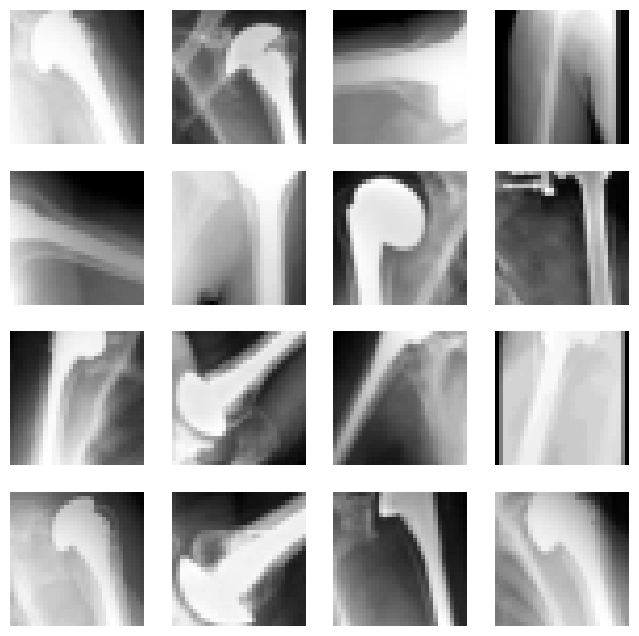

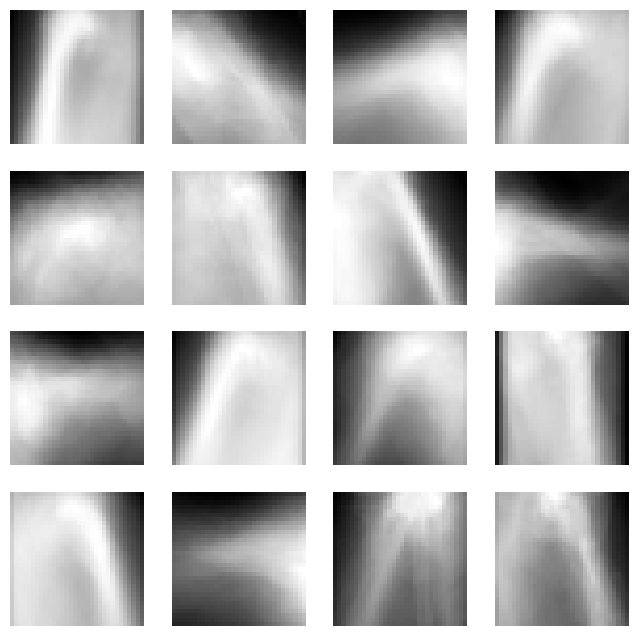

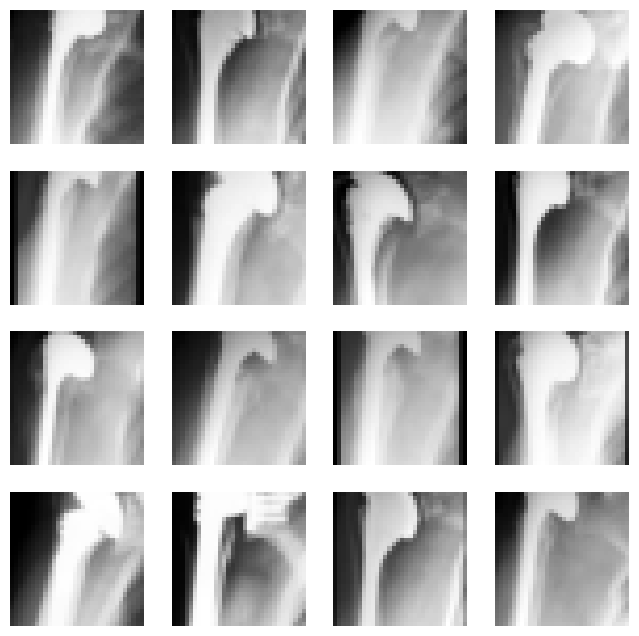

Visualizing cluster 1


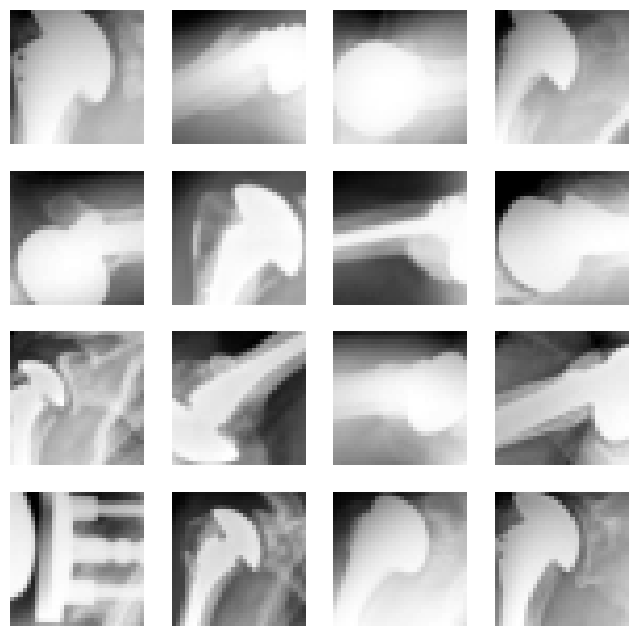

Visualizing cluster 2


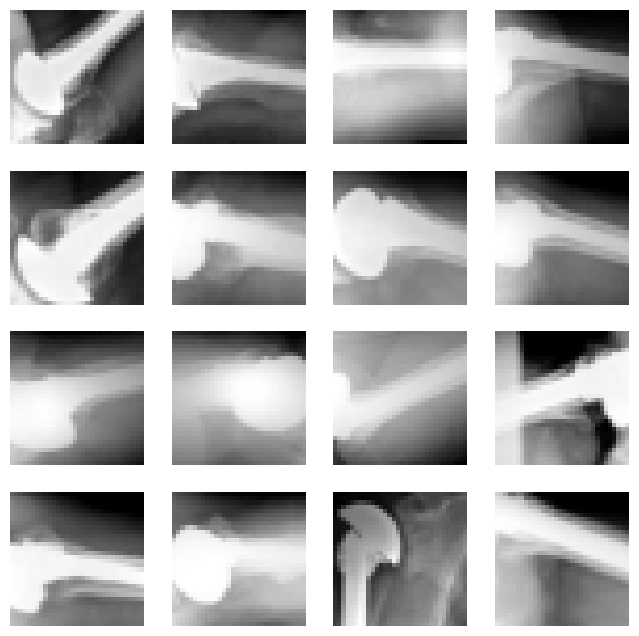

Visualizing cluster 3


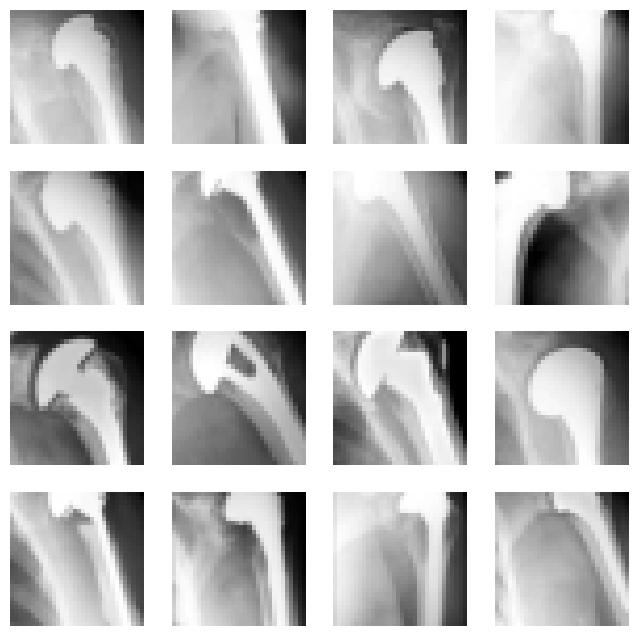

In [11]:
for k in range(4):
    print(f"Visualizing cluster {k}")
    plot_helper(X[clusters==k])
    plt.show()

As a sanity check, the following is an example of a cluster that you might get (though not guaranteed due to the randomnness at initialization):  

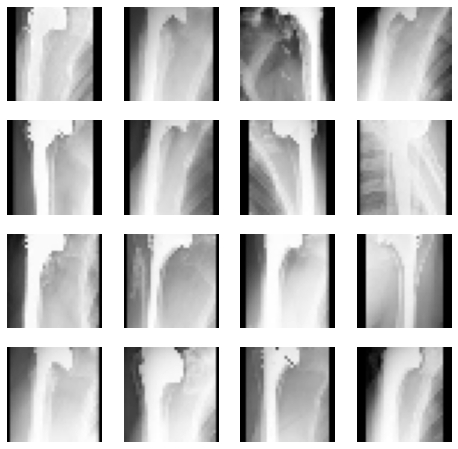

## Autograder

In [12]:
from inspect import getsource
grader.grade(test_case_id = 'kmeans_init', answer = getsource(kmeans_init))
grader.grade(test_case_id = 'kmeans_assign', answer = getsource(kmeans_assign_clusters))
grader.grade(test_case_id = 'kmeans_update_centroids', answer = getsource(kmeans_update_centroids))
grader.grade(test_case_id = 'kmeans_stopping_condition', answer = getsource(kmeans_stopping_criteria))

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.
Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.
Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.
Correct! You earned 1/1 points. You are a star!

Your submission has been successfully recorded in the gradebook.


# 2. PCA (6pts)

K-means is one of the simplest clustering algorithms. What about if we used Gaussian Mixture Models (GMMs) instead? Recall that GMMs have an assumption: that the data is drawn from a mixture of Gaussians. The further the data is from this ground truth, the worse the GMM estimate will be.

It turns out that the raw X-ray data is not drawn from a mixture of Gaussians---in fact, it is so far away that the traditional EM algorithm can't return any reasonable results! This is largely because the image data is too high dimensional, which results in singular covariance matrices.  

However, we have a tool to deal with large dimensions: we can fix this with PCA! In this second part, we're going to use PCA to reduce the dimensionality of the X-ray data.

Implement the following functions:

+ Normalize (2pts) - Given a batch of examples  $X$, normalize the examples to have zero mean and unit variance along each feature.
+ Fit PCA (2pts) - Given a batch of examples $X$ and an integer $k$, calculate the top $k$ PCA basis vectors.
+ Transform PCA (1pt) - Given a batch of examples $X$ and $k$ PCA basis vectors, transform the examples $X$ into the space spanned by the PCA basis vectors.
+ Reconstruction PCA (1pt) - Given a batch of exmaples $X$ and $k$ PCA basis vectors, calculate the best reconstruction of the examples $X$ from the PCA basis vectors.

In [13]:


def normalize(X):
    # Given a batch of examples 𝑋, normalize the examples to have zero mean
    # and unit variance along each feature.
    #
    # X := Tensor(float) of size (m,d) --- Batch of m examples of dimension d
    #
    # Return := Tensor of size (m,d) --- Normalized X along each feature

    mean = X.mean(dim=0, keepdim=True)
    std = X.std(dim=0, keepdim=True)
    return (X - mean) / std

def pca_fit(X,k):
    # Given a batch of examples 𝑋 and an integer 𝑘, calculate the top
    # 𝑘 PCA basis vectors.
    #
    # X := Tensor(float) of size (m,d) --- Batch of m examples of dimension d
    #
    # Return := Tensor of size (d, k) - The first `k` eigenvectors of the
    #       covariance matrix of `X`

    # X = normalize(X)
    # mean = X.mean(dim=0, keepdim=True)
    # std = X.std(dim=0, keepdim=True)
    # X = (X - mean) / std
    m, _ = X.size()
    cov = torch.matmul(X.T, X) / m
    eigvals, eigvecs = torch.linalg.eig(cov)
    _, indices = torch.topk( eigvals.real, k)
    return eigvecs.real[:, indices]

def pca_transform(X,V):
    # Given a batch of examples 𝑋 and 𝑘 PCA basis vectors, transform the
    # examples 𝑋 into the space spanned by the PCA basis vectors.
    #
    # X := Tensor (float) of size (m, d) - Batch of m examples of dimension d
    #
    # V := Tensor (float) of size (d, k) - First `k` principal components to
    #       use for the transformation
    #
    # Return := Tensor of size (m, k) - Transformed version of `X` projected
    #       onto the first `k` principal components represented by `V`

    # X = normalize(X)
    return torch.matmul(X, V)
    

def pca_reconstruction(X,V):
    # Given a batch of examples 𝑋 and 𝑘 PCA basis vectors, calculate the
    # best reconstruction of the examples 𝑋 from the PCA basis vectors
    #
    # X := Tensor (float) of size (m, d) - Batch of m examples of dimension d
    #
    # V := Tensor (float) of size (d, k) - The first `k` principal components
    #       used for the reconstruction
    #
    # Return := Tensor of size (m, d) - Reconstructed version of the original
    #       data `X`

   return torch.matmul(torch.matmul(X, V), V.T)

Test your code in the following cell. Plot the reconstruction error as a function of $k$.


In [14]:
# Plot reconstruction error as a function of k
ks = [2**i for i in range(8)]
losses = []
for k in ks:
    V = pca_fit(normalize(X),k)
    pca_X = pca_reconstruction(X,V)
    pca_error = F.mse_loss(pca_X,X)
    losses.append(pca_error.item())
plt.plot(ks,losses)

In [15]:
# visualize the top k PCA basis vectors

n0 = 4
fig, axs = plt.subplots(n0, n0, figsize=(8,8))
for i in range(n0*n0):
    axs[i%n0,i//n0].imshow(V[:,i].view(32,32), cmap='gray')
    axs[i%n0,i//n0].axis('off')

You should get something like the following for reconstruction error and basis vectors:


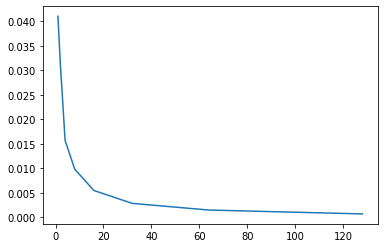

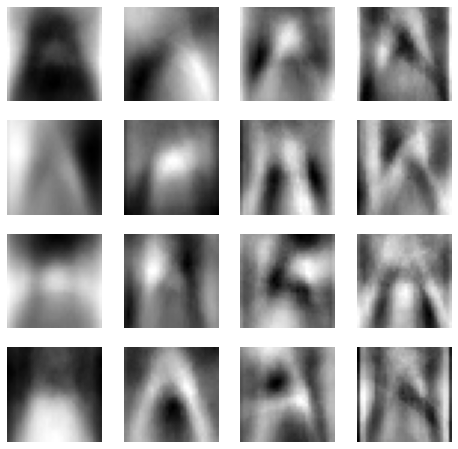

## Autograder

In [16]:
grader.grade(test_case_id = 'pca_normalize', answer = getsource(normalize))
grader.grade(test_case_id = 'pca_fit', answer = getsource(pca_fit))
grader.grade(test_case_id = 'pca_transform', answer = getsource(pca_transform))
grader.grade(test_case_id = 'pca_reconstruction', answer = getsource(pca_reconstruction))

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.
Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.
Correct! You earned 1/1 points. You are a star!

Your submission has been successfully recorded in the gradebook.
Correct! You earned 1/1 points. You are a star!

Your submission has been successfully recorded in the gradebook.


# 3. GMM and EM (17pts)

Now that we have our data living in a lower dimensional space, we are now ready to implement the EM algorithm for GMMs. Implement the following:

+ E-step (4pts) - Given a batch of examples $X$ and estimates for the cluster proportions $\pi$, cluster means $\mu$, and covariances $\Sigma$, calculate the soft cluster assignments (i.e. the probability of a cluster given an example).
+ M-step (9pts) - Given a batch of examples $X$ and the soft cluster assignments $\Gamma$, calculate new estimates for the GMM parameters.
+ EM negative log likelihood (2pts) - Given a batch of examples $X$ and the GMM parameters $(\pi, \mu, \Sigma)$, calculate the negative log likelihood.
+ EM stopping criteria (1pt) - Given the negative log likelihood of the current and previous iteration, return True if the loss has not improved by more than the provided tolerance level.
+ EM clusters (1pt) - Given the soft cluster assignments $\Gamma$, make a hard assignment of examples to the cluster with the highest likelihood.

In [17]:
def E_step(X, pis, mus, Covs):
    # Given a batch of examples X and estimates for the cluster proportions pi, cluster means mu, and
    # covariances Covs, calculate the soft cluster assignments (i.e. the probability of a cluster given an example).
    #
    # X: Tensor(float) of size(m, d) --- batch of m examples with dimension d
    # pis := Tensor(float) of size(k,) --- This is the weight of each cluster
    # mus := Tensor(float) of size(k, d) --  This is the cluster means for the k clusters
    # Covs := Tensor(float) of size(k, d, d) -- This is the covariance parameter of the Gaussian distribution
    #
    # Return := Tensor(float) of size(m, k) -- This is the result of the E step that calculates the probability
    #       of a cluster given an example
    #

    m = X.shape[0]
    k = mus.shape[0]

    pr = torch.zeros(m, k)
    for i in range(k):
        mvn = MultivariateNormal(mus[i], Covs[i])
        pr[:, i] = pis[i] * mvn.log_prob(X).exp()
    pr = pr / pr.sum(dim=1, keepdim=True)
    return pr

def M_step(X, Gamma):
    # Given a batch of example X and the soft cluster assignment gamma, calculate the new estimate of GMM parameters
    #
    # X := Tensor(float) of size(m, d) --- batch of m examples with dimension d
    # Gamma := Tensor(float) of size(m, m) --- This is the soft cluster assignment
    #
    # Return := Updated pis, mus, covs after the EM-Step

    m, _ = X.shape
    k = Gamma.shape[1]
    pis = Gamma.sum(dim=0) / m
    mus = torch.zeros(k, X.shape[1])

    Covs = torch.zeros(k, X.shape[1], X.shape[1])
    for i in range(k):
        mus[i] = (Gamma[:, i].unsqueeze(1) * X).sum(dim=0) / Gamma[:, i].sum()
        diff = X - mus[i]
        Covs[i] = torch.matmul((Gamma[:, i].unsqueeze(1) * diff).T, diff) / Gamma[:, i].sum()
    return pis, mus, Covs

def EM_neg_log_likelihood(X, pis, mus, Covs):
    # Given a batch of examples X and the GMM parameters (pi, mu, sigma), calculate the negative log likelihood.
    #
    # X: Tensor(float) of size(m, d) --- batch of m examples with dimension d
    # pis := Tensor(float) of size(k,) --- This is the weight of each cluster
    # mus := Tensor(float) of size(k, d) --  This is the cluster means for the k clusters
    # Covs := Tensor(float) of size(k, d, d) -- This is the covariance parameter of the Gaussian distribution
    #
    # Return := Tensor(float) of size(m, ) -- returns the loss

    m = X.shape[0]
    k = pis.shape[0]

    probs = torch.zeros(m)

    for i in range(k):
        mvn = MultivariateNormal(mus[i], Covs[i])
        probs += pis[i] * torch.exp(mvn.log_prob(X))

    return -torch.log(probs)

def EM_stopping_criteria(nll, nll_prev, tol=1e-4):
    # Given the negative log likelihood of the current and previous iteration,
    # return True if the loss has not improved by more than the provided tolerance level.

    # nll := Tensor(float) of size(m,) -- The negative log likelihood after the EM update
    # nll_prev := Tensor(float) of size(m,) -- The negative log likelihood before the update
    # tol := float -- the provided tolerance level for EM's stopping condition
    #
    # Return := Tensor(bool) of size (1,) --- return true if the loss has not improved by more
    # than the provided tolerance level

    return (torch.abs(nll - nll_prev) < tol).all()

def EM_clusters(Gamma):
    # Given the soft cluster assignments Gamma,
    # make a hard assignment of examples to the cluster with the highest likelihood.
    #
    # Gamma := Tensor(float) of size(m, m) --- This is the soft cluster assignment
    #
    # Return := Tensor(float) of size(m,) -- The hard cluster assignments of the examples

    return torch.argmax(Gamma, dim=1)

Test your code on the the PCA encoding of the X-ray data. Here, we're using 16 PCA basis vectors and allowing for a mixture of 8 Gaussians, but you can play around with these numbers.

In [18]:
X_gmm = pca_transform(X, pca_fit(X,16))
k = 8
niters = 50
d = X_gmm.size(1)

pis = torch.ones(k)/k
mus = kmeans_init(X_gmm,k)
Covs = torch.stack([torch.eye(d) for _ in range(k)],dim=0)

nll = None
for t in range(niters):
    prev_nll = nll

    Gamma = E_step(X_gmm, pis, mus, Covs)
    pis, mus, Covs = M_step(X_gmm, Gamma)
    Covs = Covs + 1e-4*torch.eye(d) # add some regularization

    nll = EM_neg_log_likelihood(X_gmm, pis, mus, Covs)
    if t % 5 == 0:
        print(t, nll.mean().item())
    if prev_nll is not None and EM_stopping_criteria(nll, prev_nll):
        break

print(f"Ended after {t} iterations.")
clusters = EM_clusters(Gamma)

0 19.57136344909668
5 17.649105072021484
10 17.4687442779541
15 17.364133834838867
20 17.343908309936523
25 17.336137771606445
30 17.331899642944336
35 17.331180572509766
40 17.329984664916992
45 17.325817108154297
Ended after 49 iterations.


If successful, you should get some nice visually similar clusters:

Visualizing cluster 0


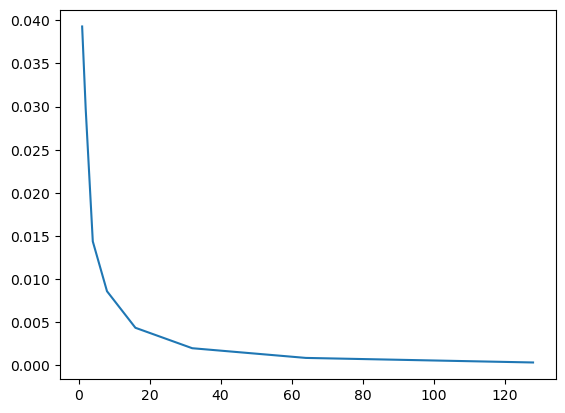

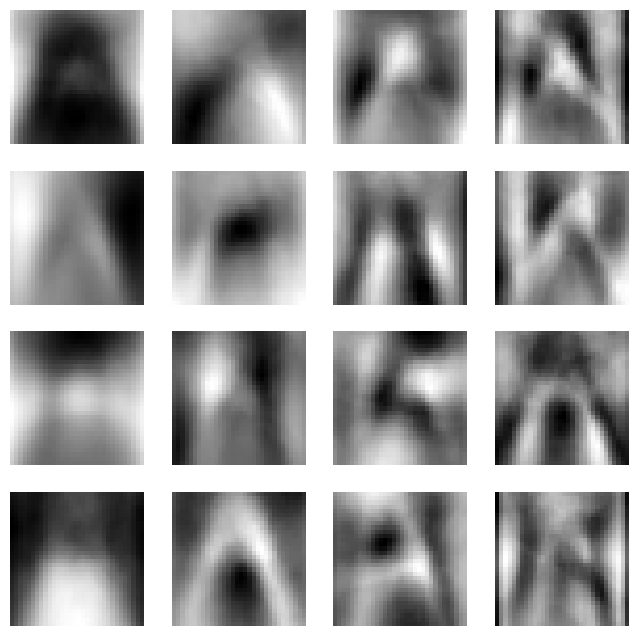

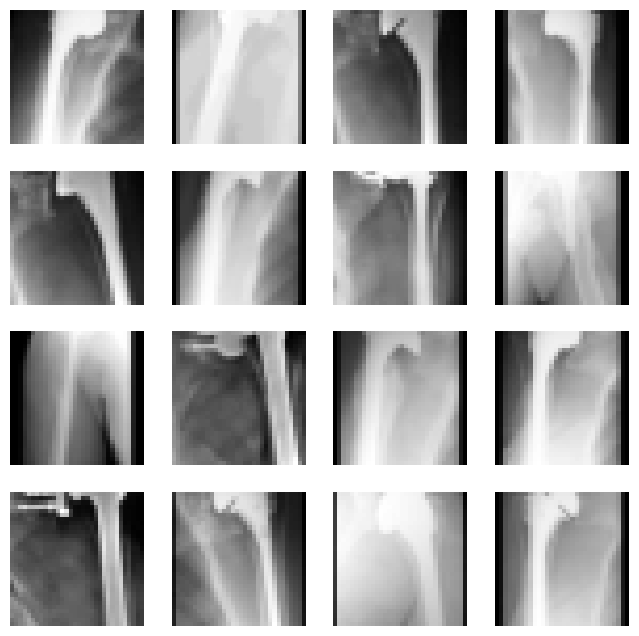

Visualizing cluster 1


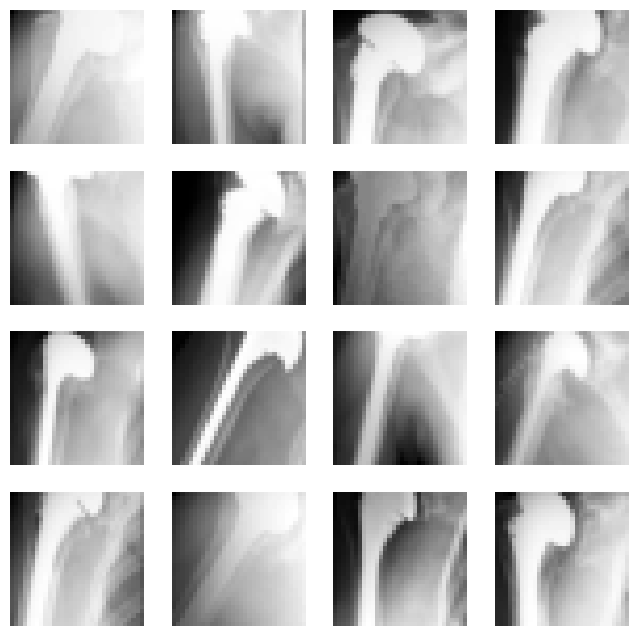

Visualizing cluster 2


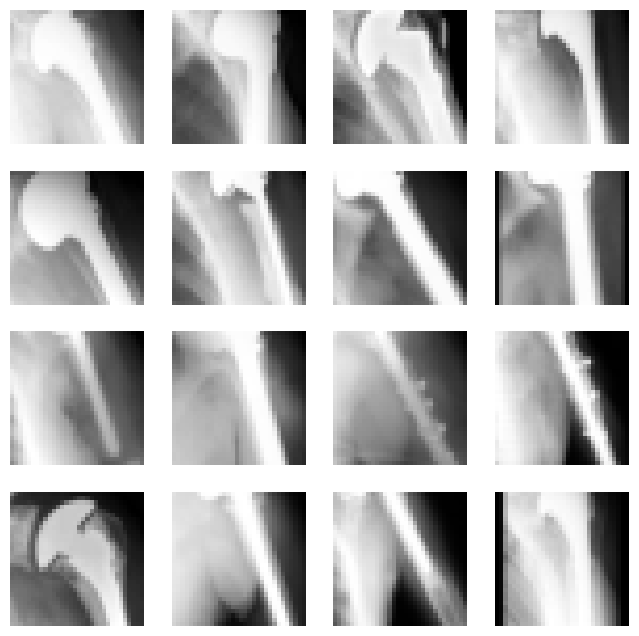

Visualizing cluster 3


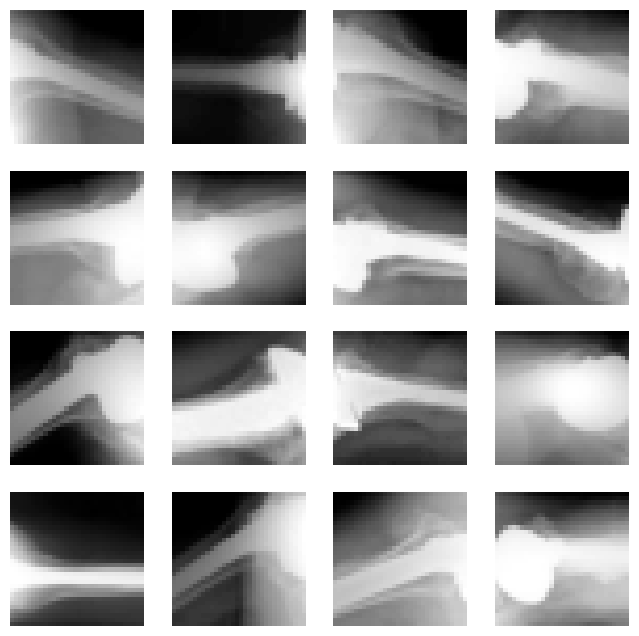

In [19]:
for k in range(4):
    if (clusters == k).sum() >= 16:
        print(f"Visualizing cluster {k}")
        plot_helper(X[clusters==k])
        plt.show()

For example, one possible cluster you might discover is the following:

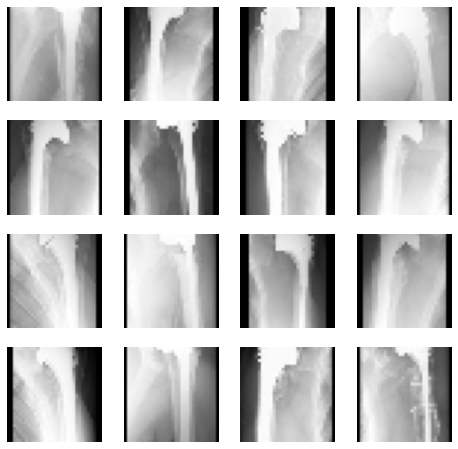

## Autograder

In [20]:
grader.grade(test_case_id = 'E_step', answer = getsource(E_step))
grader.grade(test_case_id = 'M_step', answer = getsource(M_step))
grader.grade(test_case_id = 'EM_neg_log_likelihood', answer = getsource(EM_neg_log_likelihood))
grader.grade(test_case_id = 'EM_stopping_criteria', answer = getsource(EM_stopping_criteria))
grader.grade(test_case_id = 'EM_clusters', answer = getsource(EM_clusters))

Correct! You earned 4/4 points. You are a star!

Your submission has been successfully recorded in the gradebook.
Correct! You earned 9/9 points. You are a star!

Your submission has been successfully recorded in the gradebook.
Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.
Correct! You earned 1/1 points. You are a star!

Your submission has been successfully recorded in the gradebook.
Correct! You earned 1/1 points. You are a star!

Your submission has been successfully recorded in the gradebook.
